# SQUAD Question Answering using Bert

### Overview

**Problem Statement:**

To develop a language model that given a paragraph as context, can answer questions pertaining to it.

**Abstract:**

In the task of reading comprehension or question answering, a model will be given a paragraph, and a question about that paragraph, as input. The goal is to answer the question correctly. From a research perspective, this is an interesting task because it provides a measure for how well systems can ‘understand’ text. From a more practical perspective, these systems have been extremely useful for better understanding any piece of text, and serving information needed by humans. The BERT model has revolutionized the field of Natural Language Processing. BERT based models are known to be proficient in handling context based dependencies.


In [1]:
!pip install -q transformers

     |████████████████████████████████| 2.8 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 33.0 MB/s 
     |████████████████████████████████| 636 kB 38.6 MB/s 
     |████████████████████████████████| 3.3 MB 34.1 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 


### Download the data

Stanford Question Answering Dataset (SQuAD) by [Rajpurkar et al.](https://arxiv.org/pdf/1606.05250.pdf) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

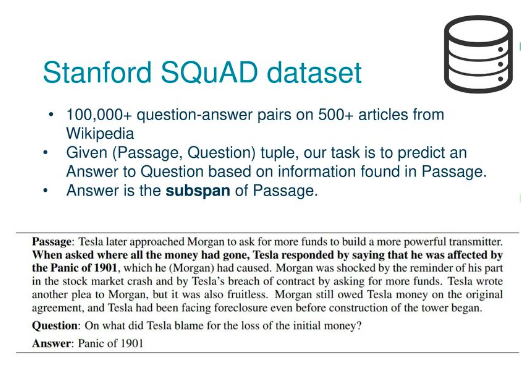

**SQuAD2.0** combines the 100,000 questions in SQuAD1.1 with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones.

Dataset link - [The Stanford Question Answering Dataset](https://rajpurkar.github.io/SQuAD-explorer/)



In [2]:
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

--2021-09-05 12:05:30--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squad/train-v2.0.json’

squad/train-v2.0.js 100%[===================>]  40.17M   150MB/s    in 0.3s    

2021-09-05 12:05:31 (150 MB/s) - ‘squad/train-v2.0.json’ saved [42123633/42123633]

--2021-09-05 12:05:31--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘squad/dev-v2.0.json’

squ

In [3]:
import os
import json
import random
import warnings
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import DistilBertTokenizerFast, DistilBertModel, AdamW

warnings.filterwarnings("ignore")


### Prepare the data


In [4]:
class SquadPreprocessor(object):
    def __init__(self, dir, tokenizer):
        """ Initializes SQUAD preprocessor.
        """
        self.dir = dir
        self.tokenizer = tokenizer

    def read_squad(self, path, frac=1.0, include_impossible=False):
        """ Reads and parses the SQUaD dataset stored in json format.
        """
        path = Path(path)
        with open(path, "rb") as f:
            squad_dict = json.load(f)

        contexts = []
        questions = []
        answers = []
        for group in squad_dict["data"]:
            for passage in group["paragraphs"]:
                # skip if random sampling is enabled
                if random.random() > frac:
                    continue
                context = passage["context"]
                for qa in passage["qas"]:
                    question = qa["question"]

                    for answer in qa["answers"]:
                        contexts.append(context)
                        questions.append(question)
                        answers.append(answer)

        return contexts, questions, answers

    def add_end_idx(self, answers, contexts):
        """ Calculates position of the end answer and corrects known shifts in dataset (in-place).
        """
        for answer, context in zip(answers, contexts):
            gold_text = answer["text"]
            start_idx = answer["answer_start"]
            end_idx = start_idx + len(gold_text)

            # sometimes squad answers are off by a character or two so performing
            # a sanity check and fixing if any such case
            if context[start_idx:end_idx] == gold_text:
                answer["answer_end"] = end_idx
            # when the gold label is off by one character
            elif context[start_idx - 1 : end_idx - 1] == gold_text:
                answer["answer_start"] = start_idx - 1
                answer["answer_end"] = end_idx - 1
            elif context[start_idx + 1 : end_idx + 1] == gold_text:
                answer["answer_start"] = start_idx + 1
                answer["answer_end"] = end_idx + 1
            # when the gold label is off by two characters
            elif context[start_idx - 2 : end_idx - 2] == gold_text:
                answer["answer_start"] = start_idx - 2
                answer["answer_end"] = end_idx - 2
            elif context[start_idx + 2 : end_idx + 2] == gold_text:
                answer["answer_start"] = start_idx + 2
                answer["answer_end"] = end_idx + 2

    def add_token_position(self, encodings, answers):
        """ Updates start and end positions for answer tokens w.r.t. truncated context. 
        """
        start_positions = []
        end_positions = []
        for i in range(len(answers)):
            start_positions.append(
                encodings.char_to_token(i, answers[i]["answer_start"])
            )
            end_positions.append(
                encodings.char_to_token(i, answers[i]["answer_end"] - 1)
            )

            # if start position is None, the answer passage has been truncated
            if start_positions[-1] is None:
                start_positions[-1] = self.tokenizer.model_max_length
            if end_positions[-1] is None:
                end_positions[-1] = self.tokenizer.model_max_length

        encodings.update(
            {"start_positions": start_positions, "end_positions": end_positions}
        )

    def get_encodings(self, random_sample_train, random_sample_val, **tokenizer_kwargs):
        """ Pre-process and get encodings. Allows random sampling to speed up training.
        """
        train_contexts, train_questions, train_answers = self.read_squad(
            os.path.join(self.dir, "train-v2.0.json"), frac=random_sample_train
        )
        val_contexts, val_questions, val_answers = self.read_squad(
            os.path.join(self.dir, "dev-v2.0.json"), frac=random_sample_val
        )

        self.add_end_idx(train_answers, train_contexts)
        self.add_end_idx(val_answers, val_contexts)

        train_encodings = self.tokenizer(
            train_contexts,
            train_questions,
            truncation=True,
            padding=True,
            **tokenizer_kwargs
        )
        val_encodings = self.tokenizer(
            val_contexts,
            val_questions,
            truncation=True,
            padding=True,
            **tokenizer_kwargs
        )

        self.add_token_position(train_encodings, train_answers)
        self.add_token_position(val_encodings, val_answers)

        return train_encodings, val_encodings


In [5]:
class SquadDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)


In [6]:
# sanity check for the dataset
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

squad_preprocessor = SquadPreprocessor("squad", tokenizer)
train_enc, val_enc = squad_preprocessor.get_encodings(
    random_sample_train=0.001, random_sample_val=0.1, return_tensors="pt"
)

train_dataset = SquadDataset(train_enc)
train_loader = DataLoader(train_dataset, batch_size=64)


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

### Model

BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.
As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).

**Fine Tuning BERT for Question-Answering Systems:**

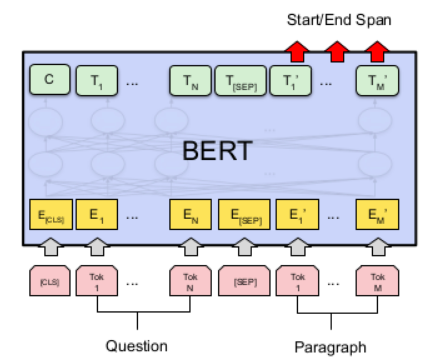

For the Question Answering task, BERT takes the input question and passage as a single packed sequence. The input embeddings are the sum of the token embeddings and the segment embeddings. The input is processed in the following way before entering the model:
1. Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the question and a [SEP] token is inserted at the end of both the question and the paragraph.
2. Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. This allows the model to distinguish between sentences. In the below example, all tokens marked as A belong to the question, and those marked as B belong to the paragraph.

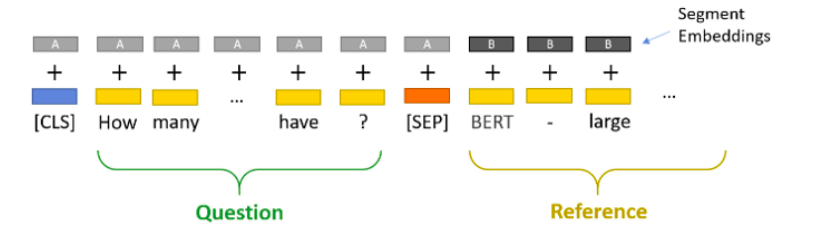

3. To fine-tune BERT for a Question-Answering system, a fully connected linear layer $W \in R^{2×h}$ is added.

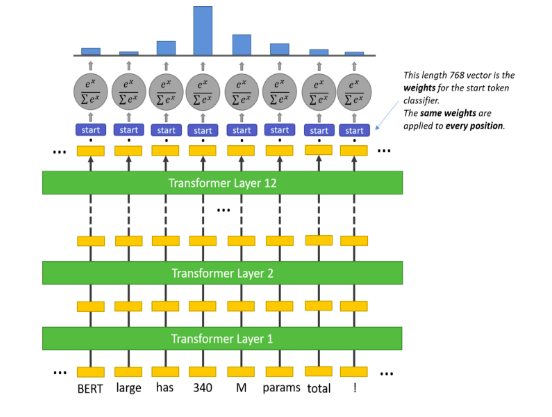

4. The probability of each word being the start-word is calculated by taking a dot product between the final embedding of the word $T_i \in R^h$ and the start vector, followed by a softmax over all the words. The word with the highest probability value is considered as the start-word of the span. Similar process followed for the end-word of the span.
5. Specifically for SQuAD 2.0, The non-answerable solution is using [CLS] token as the ground truth. As a result, the predicted answer's start position and end position are equal to −1.


In [7]:
class QAModel(nn.Module):
    def __init__(self, transformer_model, device, dropout_rate=0.2):
        """ Initializes SQUAD QA model.
        """
        super(QAModel, self).__init__()
        self.device = device
        self.qa_base = transformer_model
        self.embed_dim = self.qa_base.config.dim

        # replace the head with linear layer
        self.qa_head = nn.Linear(in_features=self.embed_dim, out_features=2, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, input_enc):
        """ Forward step for the question-answering model.
        """
        # for real data, start and end positions won't be present
        start_pos = input_enc.pop("start_positions", None)
        end_pos = input_enc.pop("end_positions", None)

        # for training, transform start and end position lists into tensors
        input_ids = input_enc["input_ids"].to(self.device)
        attention_mask = input_enc["attention_mask"].to(self.device)

        out = self.qa_base(input_ids, attention_mask)

        # extract hidden state from base model output
        hidden_out = out.last_hidden_state  # (batch_size, len_sentence, embed_dim)
        hidden_out = self.dropout(hidden_out)  # (batch_size, len_sentence, embed_dim)

        # pass through the linear layer, we need to learn parameters
        out = self.qa_head(hidden_out)  # (batch_size, len_sentence, 2)

        start_logit, end_logit = out.split(1, dim=-1)
        start_logit = start_logit.squeeze(-1)  # (bs, max_query_len)
        end_logit = end_logit.squeeze(-1)

        if start_pos is not None and end_pos is not None:
            start_pos = torch.LongTensor(start_pos)
            end_pos = torch.LongTensor(end_pos)

        return start_logit, start_pos, end_logit, end_pos

    def save(self, path, epoch, optimizer, train_loss, eval_loss):
        """ Persist model on disk.
        """
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": self.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss": train_loss,
                "eval_loss": eval_loss,
            },
            path,
        )

    def compute_loss(self, start_logit, start_pos, end_logit, end_pos):
        """ Computes loss for question-answering task.
        """
        ignored_idx = start_logit.size(1)
        start_pos.clamp_(0, ignored_idx)
        end_pos.clamp_(0, ignored_idx)

        loss_fn = nn.CrossEntropyLoss(ignore_index=ignored_idx)

        start_logit_g = start_logit.to(self.device, non_blocking=True)
        end_logit_g = end_logit.to(self.device, non_blocking=True)
        start_pos_g = start_pos.to(self.device, non_blocking=True)
        end_pos_g = end_pos.to(self.device, non_blocking=True)

        start_loss = loss_fn(start_logit_g, start_pos_g)
        end_loss = loss_fn(end_logit_g, end_pos_g)

        return (start_loss + end_loss) / 2


In [8]:
# sanity check for the model architecture
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

squad_preprocessor = SquadPreprocessor("squad", tokenizer)
train_enc, val_enc = squad_preprocessor.get_encodings(
    random_sample_train=0.001, random_sample_val=0.1, return_tensors="pt"
)

train_dataset = SquadDataset(train_enc)
train_loader = DataLoader(train_dataset, batch_size=4)

transformer_model = DistilBertModel.from_pretrained(
    "distilbert-base-uncased", return_dict=True
)
model = QAModel(transformer_model=transformer_model, device=torch.device("cpu"))

for train_data in train_loader:
    start_logit, start_pos_, end_logit, end_pos_ = model(train_data)
    print(model.compute_loss(start_logit, start_pos_, end_logit, end_pos_))
    break


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor(6.0210, grad_fn=<DivBackward0>)


### Training


In [9]:
frac_train_data = 0.025
frac_val_data = 0.025
batch_size = 8
learning_rate = 5e-5
n_epoch = 5
save_model_prefix = "squad"
best_loss = float("inf")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

squad_preprocessor = SquadPreprocessor("squad", tokenizer)
train_enc, val_enc = squad_preprocessor.get_encodings(
    random_sample_train=frac_val_data,
    random_sample_val=frac_train_data,
    return_tensors="pt",
)

train_dataset = SquadDataset(train_enc)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SquadDataset(val_enc)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [11]:
transformer_model = DistilBertModel.from_pretrained(
    "distilbert-base-uncased", return_dict=True
)
model = QAModel(transformer_model=transformer_model, device=device).to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)

if not os.path.exists("model_checkpoint"):
    os.makedirs("model_checkpoint")

for epoch in range(n_epoch):
    print(f"epoch: {epoch + 1} / {n_epoch}")
    print("-" * 20)

    train_loss = 0
    val_loss = 0
    train_steps = 0
    val_steps = 0

    model.train()

    tk0 = tqdm(train_loader, total=len(train_loader), position=0, leave=True)

    with torch.set_grad_enabled(True):
        for idx, data in enumerate(tk0):
            # forward pass
            out = model(data)
            loss = model.compute_loss(*out)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_steps += 1
            tk0.set_postfix(loss=train_loss / train_steps)

    tk0.close()

    model.eval()

    tk0 = tqdm(val_loader, total=len(val_loader), position=0, leave=True)

    with torch.no_grad():
        for idx, data in enumerate(tk0):
            out = model(data)
            loss = model.compute_loss(*out)

            val_loss += loss.item()
            val_steps += 1
            tk0.set_postfix(loss=val_loss / val_steps)

    tk0.close()

    if best_loss > (val_loss / val_steps):
        print(f"Saving the best model")
        model.save(
            f"model_checkpoint/{save_model_prefix}_model_best_epoch.pt",
            epoch=epoch,
            optimizer=optimizer,
            train_loss=train_loss / train_steps,
            eval_loss=val_loss / val_steps,
        )
        best_loss = val_loss / val_steps


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 1 / 5
--------------------


  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

Saving the best model
epoch: 2 / 5
--------------------


  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

Saving the best model
epoch: 3 / 5
--------------------


  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch: 4 / 5
--------------------


  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch: 5 / 5
--------------------


  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

### Inference

In [12]:
class QAModelInference(object):
    def __init__(self, model_path, tokenizer, device):
        """ Initializes SQUAD QA Inference model.
        """
        self.model_path = model_path
        self.device = device
        self.tokenizer = tokenizer
        self.model = self.load_model(model_path)

    def load_model(self, state_path):
        """ Loads the QA inference model checkpoint from a specified path.
        """
        if not os.path.exists(state_path):
            raise FileExistsError(f"Model path {state_path} does not exist!")

        transformer_model = DistilBertModel.from_pretrained(
            "distilbert-base-uncased", return_dict=True
        )
        model = QAModel(transformer_model=transformer_model, device=self.device).to(
            self.device
        )

        checkpoint = torch.load(state_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])

        model.eval()

        return model

    def get_model_data(self, model, context, question):
        """ Extracts start and stop locations, words and location probabilities given the model instance, tokenizer,
            context and question.
        """
        tokens = self.tokenizer(
            context, question, truncation=True, padding=True, return_tensors="pt"
        )
        start_logit, _, end_logit, _ = model(tokens)

        # convert to proper probabilities
        start_logit, end_logit = (
            torch.softmax(start_logit, dim=1),
            torch.softmax(end_logit, dim=1),
        )
        start_idx, end_idx = torch.argmax(start_logit), torch.argmax(end_logit) + 1

        words = ""
        if end_idx < start_idx:
            end_idx = torch.argmax(end_logit[0][start_idx:]) + 1
        else:
            input_ids = tokens["input_ids"].squeeze(0)
            words = self.tokenizer.decode(
                token_ids=input_ids[start_idx:end_idx].to("cpu").numpy()
            )

        return (
            start_idx,
            end_idx,
            words,
            start_logit.detach().to("cpu").numpy(),
            end_logit.detach().to("cpu").numpy(),
        )

    def extract_answer(self, context, question):
        """ Extracts probable answer for the question w.r.t. context
        """
        # get data for possible answers
        start_pos, end_pos, words, start_proba, end_proba = self.get_model_data(
            self.model, context, question
        )

        return {
            "answer": words,
            "start_word_proba": start_proba,
            "end_word_proba": end_proba,
            "start_pos": start_pos,
            "end_pos": end_pos,
        }


In [13]:
#@title Question Answering System
#@markdown Enter the context and question to get the response.
context = "Immigrants arrived from all over the world to search for gold, especially from Ireland and China. Many Chinese miners worked in Victoria, and their legacy is particularly strong in Bendigo and its environs. Although there was some racism directed at them, there was not the level of anti-Chinese violence that was seen at the Lambing Flat riots in New South Wales. However, there was a riot at Buckland Valley near Bright in 1857. Conditions on the gold fields were cramped and unsanitary; an outbreak of typhoid at Buckland Valley in 1854 killed over 1,000 miners." #@param {type:"string"}
question = "Where is the Asian influence strongest in Victoria?" #@param {type:"string"}

def predict(context, question):
    model_path = os.path.join(
        'model_checkpoint', 'squad_model_best_epoch.pt'
    )
    inference = QAModelInference(model_path, tokenizer, device)
    output = inference.extract_answer(context, question)
    print(f"answer: {output['answer']}")

predict(context, question)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


answer: bendigo and its environs


In [14]:
#@title Question Answering System
#@markdown Enter the context and question to get the response.
context = "In 1984, Time Magazine reported that Sassafras, a female poodle belonging to a New York City physician, had received a diploma from the American Association of Nutrition and Dietary Consultants.  Her owner had bought the diploma for $50 to demonstrate that \"something that looks like a diploma doesn't mean that somebody has responsible training\"." #@param {type:"string"}
question = "Who Sassafras belongs to?" #@param {type:"string"}

def predict(context, question):
    model_path = os.path.join(
        'model_checkpoint', 'squad_model_best_epoch.pt'
    )
    inference = QAModelInference(model_path, tokenizer, device)
    output = inference.extract_answer(context, question)
    print(f"answer: {output['answer']}")

predict(context, question)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


answer: poodle belonging to a new york city physician


In [15]:
#@title Question Answering System
#@markdown Enter the context and question to get the response.
context = " Steam engines can be said to have been the moving force behind the Industrial Revolution and saw widespread commercial use driving machinery in factories, mills and mines; powering pumping stations; and propelling transport appliances such as railway locomotives, ships, steamboats and road vehicles. Their use in agriculture led to an increase in the land available for cultivation. There have at one time or another been steam-powered farm tractors, motorcycles (without much success) and even automobiles as the Stanley Steamer." #@param {type:"string"}
question = "What is an example of a steam-powered automobile?" #@param {type:"string"}

def predict(context, question):
    model_path = os.path.join(
        'model_checkpoint', 'squad_model_best_epoch.pt'
    )
    inference = QAModelInference(model_path, tokenizer, device)
    output = inference.extract_answer(context, question)
    print(f"answer: {output['answer']}")

predict(context, question)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


answer: stanley steamer


### References

1. [SQUAD 2.0 Dataset](https://rajpurkar.github.io/SQuAD-explorer/)
2. [BERT Paper](https://arxiv.org/pdf/1810.04805.pdf)
3. [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
4. [Build a Smart Question Answering System with Fine-Tuned BERT](https://medium.com/saarthi-ai/build-a-smart-question-answering-system-with-fine-tuned-bert-b586e4cfa5f5)
5. [Hugging Face](https://huggingface.co/)
